In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
heigh = 256

In [4]:
path = 'castom-masks/train/'
trainimagepath = path + 'img/*'
maskspath = path + 'masks_machine/'

In [5]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   mask = maskspath + get_mask(file_path)
   mask = tf.io.read_file(mask)
   mask = tf.image.decode_png(mask)
   cond = tf.greater_equal(mask,1)
   mask = tf.where(cond,1,0)
   return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   print(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*8,heigh*8,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*8,heigh*8,1),seed=int(seed))
   return input_image, input_mask

def adjust_brightness(input_image, input_mask):
   input_image = tf.image.adjust_brightness(input_image,delta=0.1)
   return input_image, input_mask

def adjust_gamma(input_image, input_mask):
   input_image = tf.image.adjust_gamma(input_image)
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.float32)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_gamma)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_brightness)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(64)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [6]:
#unet
#encoder x:
def encoder_x(x,n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

#decoder_x:
def decoder_x(x,skip_connections,n_filters):
    x = tf.keras.layers.concatenate([x,skip_connections])
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

#output
def output(x):
    return tf.keras.layers.Conv2DTranspose(1,3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False,activation='sigmoid')(x)


def buildmodel():
    inputlayer = tf.keras.layers.Input(shape=(256,256,3))
    print(inputlayer)
    e1 = encoder_x(inputlayer,64)
    e2 = encoder_x(e1,128)
    e3 = encoder_x(e2,256)
    e4 = encoder_x(e3,512)
    e5 = encoder_x(e4,512)
    e6 = encoder_x(e5,512)
    e7 = encoder_x(e6,512)
    x = decoder_x(e7,e7,512)
    x = decoder_x(x,e6,512)
    x = decoder_x(x,e5,512)
    x = decoder_x(x,e4,256)
    x = decoder_x(x,e3,128)
    x = decoder_x(x,e2,64)
    x = tf.keras.layers.concatenate([x,e1])
    outputlayer = output(x)
    print(outputlayer)
    
    unet_model = tf.keras.Model(inputlayer, outputlayer, name="U-Net")

    return unet_model

In [7]:
#dice coef
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))

def custom_dice_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) * 0.5 + tf.keras.losses.BinaryCrossentropy()(y_true,y_pred)

In [8]:
model = buildmodel()
model.compile(optimizer = 'adam', loss = [custom_dice_loss], metrics = ['accuracy',[dice_coef]])
#tf.keras.utils.plot_model(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [9]:
def scheduler(epoch, lr):
  if epoch < 10 or epoch % 2 == 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [10]:
callback =[tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=3,verbose=1),
           tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
           tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='loss',verbose=1)
]

In [11]:
data = tf_dataset(trainimagepath,learning = True)

In [12]:
path = 'castom-masks/val/'
valimagepath = path + 'img/*'
maskspath = path + 'masks_machine/'

In [13]:
valdata = tf_dataset(valimagepath,learning = True)
valdata = valdata.batch(4)

In [14]:
len(data)

704

In [15]:
len(valdata)

64

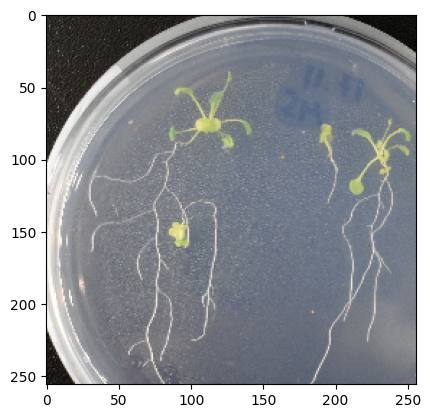

tf.Tensor([], shape=(0,), dtype=float32)


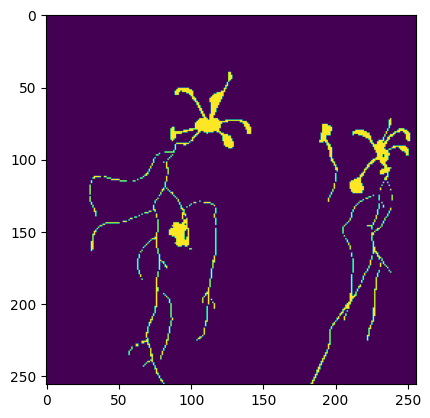

In [16]:
for image,mask in data.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        print(mask[mask > 1])

In [17]:
model_history = model.fit(data.batch(4),
                          epochs=30,
                          validation_data=valdata, 
                          callbacks=callback)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
176/176 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.9638 - dice_coef: 0.2283
Epoch 1: loss improved from inf to 0.50975, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 136s 720ms/step - loss: 0.5097 - accuracy: 0.9638 - dice_coef: 0.2283 - val_loss: 0.5736 - val_accuracy: 0.9781 - val_dice_coef: 0.0854 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
176/176 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9933 - dice_coef: 0.5843
Epoch 2: loss improved from 0.50975 to 0.23700, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 130s 717ms/step - loss: 0.2370 - accuracy: 0.9933 - dice_coef: 0.5843 - val_loss: 0.3988 - val_accuracy: 0.9837 - val_dice_coef: 0.4278 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
176/176 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9946 - dice_coef: 0.6812
Epoch 3: loss improved from 0.23700 to 0.18503, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 130s 717ms/step - loss: 0.1850 - accuracy: 0.9946 - dice_coef: 0.6812 - val_loss: 0.2729 - val_accuracy: 0.9874 - val_dice_coef: 0.6192 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
176/176 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9950 - dice_coef: 0.7148
Epoch 4: loss improved from 0.18503 to 0.16724, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 132s 727ms/step - loss: 0.1672 - accuracy: 0.9950 - dice_coef: 0.7148 - val_loss: 0.2345 - val_accuracy: 0.9886 - val_dice_coef: 0.6784 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/30
176/176 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9953 - dice_coef: 0.7281
Epoch 5: loss improved from 0.16724 to 0.15947, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 727ms/step - loss: 0.1595 - accuracy: 0.9953 - dice_coef: 0.7281 - val_loss: 0.2265 - val_accuracy: 0.9889 - val_dice_coef: 0.6876 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/30
176/176 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9955 - dice_coef: 0.7482
Epoch 6: loss improved from 0.15947 to 0.14848, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 723ms/step - loss: 0.1485 - accuracy: 0.9955 - dice_coef: 0.7482 - val_loss: 0.2383 - val_accuracy: 0.9888 - val_dice_coef: 0.6855 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/30
176/176 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9957 - dice_coef: 0.7641
Epoch 7: loss improved from 0.14848 to 0.13932, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 722ms/step - loss: 0.1393 - accuracy: 0.9957 - dice_coef: 0.7641 - val_loss: 0.2150 - val_accuracy: 0.9898 - val_dice_coef: 0.7183 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/30
176/176 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9957 - dice_coef: 0.7583
Epoch 8: loss did not improve from 0.13932
176/176 [==============================] - 125s 687ms/step - loss: 0.1426 - accuracy: 0.9957 - dice_coef: 0.7583 - val_loss: 0.2607 - val_accuracy: 0.9884 - val_dice_coef: 0.6635 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/30
176/176 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9960 - dice_coef: 0.7735
Epoch 9: loss improved from 0.13932 to 0.13378, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 722ms/step - loss: 0.1338 - accuracy: 0.9960 - dice_coef: 0.7735 - val_loss: 0.1946 - val_accuracy: 0.9903 - val_dice_coef: 0.7386 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/30
176/176 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9960 - dice_coef: 0.7741
Epoch 10: loss improved from 0.13378 to 0.13358, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 726ms/step - loss: 0.1336 - accuracy: 0.9960 - dice_coef: 0.7741 - val_loss: 0.2179 - val_accuracy: 0.9896 - val_dice_coef: 0.7159 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 11/30
176/176 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9961 - dice_coef: 0.7849
Epoch 11: loss improved from 0.13358 to 0.12735, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 725ms/step - loss: 0.1274 - accuracy: 0.9961 - dice_coef: 0.7849 - val_loss: 0.2054 - val_accuracy: 0.9902 - val_dice_coef: 0.7279 - lr: 9.0484e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 12/30
176/176 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9962 - dice_coef: 0.7923
Epoch 12: loss improved from 0.12735 to 0.12269, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 132s 730ms/step - loss: 0.1227 - accuracy: 0.9962 - dice_coef: 0.7923 - val_loss: 0.1814 - val_accuracy: 0.9909 - val_dice_coef: 0.7607 - lr: 9.0484e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 13/30
176/176 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9963 - dice_coef: 0.8008
Epoch 13: loss improved from 0.12269 to 0.11759, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 725ms/step - loss: 0.1176 - accuracy: 0.9963 - dice_coef: 0.8008 - val_loss: 0.1852 - val_accuracy: 0.9909 - val_dice_coef: 0.7523 - lr: 8.1873e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 14/30
176/176 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9964 - dice_coef: 0.8047
Epoch 14: loss improved from 0.11759 to 0.11555, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 725ms/step - loss: 0.1155 - accuracy: 0.9964 - dice_coef: 0.8047 - val_loss: 0.1769 - val_accuracy: 0.9912 - val_dice_coef: 0.7686 - lr: 8.1873e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 15/30
176/176 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9966 - dice_coef: 0.8143
Epoch 15: loss improved from 0.11555 to 0.10989, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 725ms/step - loss: 0.1099 - accuracy: 0.9966 - dice_coef: 0.8143 - val_loss: 0.2044 - val_accuracy: 0.9902 - val_dice_coef: 0.7311 - lr: 7.4082e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 16/30
176/176 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9965 - dice_coef: 0.8139
Epoch 16: loss did not improve from 0.10989
176/176 [==============================] - 125s 688ms/step - loss: 0.1104 - accuracy: 0.9965 - dice_coef: 0.8139 - val_loss: 0.1862 - val_accuracy: 0.9911 - val_dice_coef: 0.7569 - lr: 7.4082e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 17/30
176/176 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9967 - dice_coef: 0.8192
Epoch 17: loss improved from 0.10989 to 0.10681, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


176/176 [==============================] - 131s 725ms/step - loss: 0.1068 - accuracy: 0.9967 - dice_coef: 0.8192 - val_loss: 0.1801 - val_accuracy: 0.9912 - val_dice_coef: 0.7675 - lr: 6.7032e-04
Epoch 17: early stopping


In [18]:
test = tf_dataset('cropped/AAE_0133.png',learning=False)
pred_mask = model.predict(test)

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)
1/1 [==============================] - 1s 1s/step


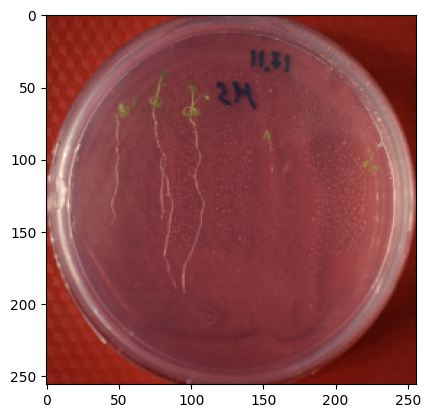

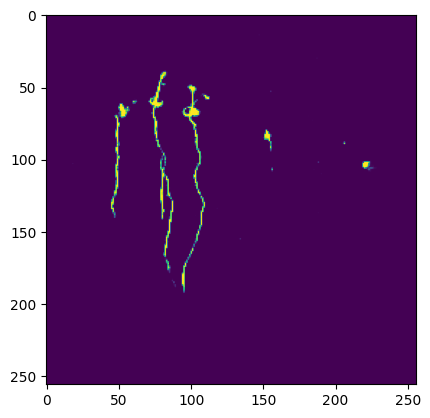

In [19]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])

In [20]:
model.save(filepath='models/model', save_format="h5",overwrite=True)

In [23]:
loadedmodel = tf.keras.models.load_model('bestmodel',compile=False)

In [24]:
loadedmodel.compile(optimizer = 'adam', loss = [custom_dice_loss], metrics = ['accuracy',[dice_coef]])

In [25]:
test = tf_dataset('cropped/AAE_0133.png',learning=False)
pred_mask = loadedmodel.predict(test)

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)
1/1 [==============================] - 0s 484ms/step


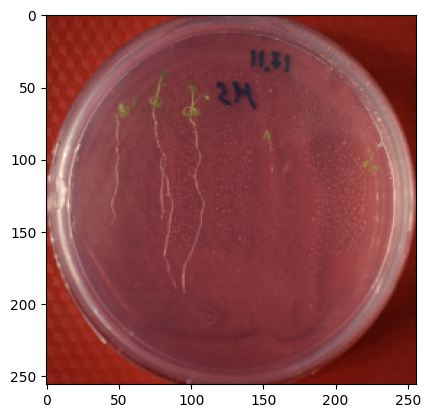

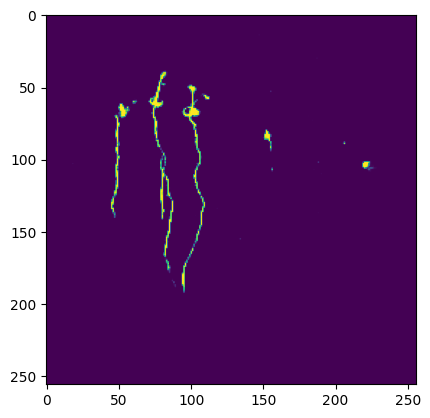

In [26]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])